In [28]:
from config import *
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret_id))

In [2]:
song = pd.read_csv('../Data/raw/song_comp.csv')
song.head()

,song,artist,album_release_date
0,Supermodel (You Better Work),RuPaul,1993-06-08
1,We Break the Dawn,Michelle Williams,2008-04-15
2,The Greatest Love of All,Whitney Houston,1985-02-14
3,Would I Lie to You?,Eurythmics,1985-04-29
4,Stronger,Britney Spears,2000-05-16


In [3]:
song['release_year']=song['album_release_date'].apply(lambda x: str(x).split("-")[0])
song['release_decade'] = song['release_year'].apply(lambda x: 0 if x==0 else list(str(x))[2]+str(0))
song = song.drop(song.loc[song['release_decade']=='n0'].index)
song['release_decade'].value_counts(dropna=False)

song_decade = song.groupby(['release_decade','artist'],as_index=False).agg({'song':'count'})
song_decade

,release_decade,artist,song
0,00,(Mis-Teeq,1
1,00,Alicia Keys,1
2,00,Amy Winehouse,1
3,00,Anouk,1
4,00,Aretha Franklin,1
...,...,...,...
265,90,Thelma Houston,1
266,90,"Ultra Naté, Amber, Jocelyn Enriquez",1
267,90,Vengaboys,1
268,90,Whitney Houston,1


In [4]:
def decade_star(df): 
    decade_list = list(song_decade['release_decade'].unique())
    artist_list = []
    dec = []
    song_num = []
    for decade in decade_list: 
        max_song = df[(df['release_decade']==decade)]['song'].max()
        artist = list(df['artist'][(df['release_decade']==decade) & (df['song']==max_song)])[0]
        dec.append(decade)
        artist_list.append(artist)
        song_num.append(max_song)
    decade_dict = {'decade':dec,'artist of the decade':artist_list,'count':song_num}
    decade_df = pd.DataFrame.from_dict(decade_dict)
    return decade_df

decade_pd = decade_star(song_decade)
decade_pd = decade_pd.reindex([3,4,5,6,7,8,0,1,2]).reset_index(drop=True)
decade_pd

,decade,artist of the decade,count
0,40,Ethel Merman,1
1,50,Judy Garland,1
2,60,Aretha Franklin,3
3,70,Blondie,2
4,80,Janet Jackson,4
5,90,En Vogue,4
6,00,Britney Spears,6
7,10,RuPaul,9
8,20,Dua Lipa,4


In [5]:
def search_song(title,artist):
    try: 
        string = "tracks: " + title + "artist: " + artist
        song=sp.search(q=string,limit=1)
        id = song['tracks']['items'][0]['id']
    except:
        id = np.nan
    
    return id

In [6]:
song['id'] = list(map(search_song,song['song'],song['artist']))
song.head()

,song,artist,album_release_date,release_year,release_decade,id
0,Supermodel (You Better Work),RuPaul,1993-06-08,1993,90,36Rpz4MZQhGknLEmTmHr8v
1,We Break the Dawn,Michelle Williams,2008-04-15,2008,00,01drW5lmrI1SWrSkDzivsj
2,The Greatest Love of All,Whitney Houston,1985-02-14,1985,80,6yJxCltgtmGxIgKOS6ndnu
3,Would I Lie to You?,Eurythmics,1985-04-29,1985,80,1lJZSsMoWEbrgaY6CxPMf8
4,Stronger,Britney Spears,2000-05-16,2000,00,5QhBKPqsnX1uY9fZNaAtZg


In [7]:
display(song.shape)
song = song.dropna().reset_index(drop=True)
song.shape

(349, 6)

(346, 6)

In [8]:
def get_audio_features(list_of_songs_ids):
    features = sp.audio_features(list_of_songs_ids)
    return features

In [9]:
from time import sleep
from random import randint
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

song_id = list(song['id'])        
split_id = list(chunks(song_id,100))

In [10]:
audio=[]
for i in range(len(split_id)):
    audio.append(get_audio_features(list(split_id[i])))
    sleep(10)
    
data_total = pd.DataFrame()
data_list=[]
for i in audio:
    for j in i:
        d={}
        for key,val in j.items():
            d[key] = [val]
        data_total =pd.concat([data_total, pd.DataFrame(d)], axis=0)

data_total = data_total.reset_index(drop=True)
data_total = data_total.drop(columns='id')
song = pd.concat([song,data_total],axis=1)
display(song.isna().sum())
song.head()

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
dtype: int64

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,Supermodel (You Better Work),RuPaul,1993-06-08,1993,90,36Rpz4MZQhGknLEmTmHr8v,0.792,0.562,7,-11.379,...,0.000075,0.428,0.592,126.221,audio_features,spotify:track:36Rpz4MZQhGknLEmTmHr8v,https://api.spotify.com/v1/tracks/36Rpz4MZQhGk...,https://api.spotify.com/v1/audio-analysis/36Rp...,239933,4
1,We Break the Dawn,Michelle Williams,2008-04-15,2008,00,01drW5lmrI1SWrSkDzivsj,0.708,0.635,4,-5.304,...,0.000495,0.109,0.387,110.978,audio_features,spotify:track:01drW5lmrI1SWrSkDzivsj,https://api.spotify.com/v1/tracks/01drW5lmrI1S...,https://api.spotify.com/v1/audio-analysis/01dr...,236147,4
2,The Greatest Love of All,Whitney Houston,1985-02-14,1985,80,6yJxCltgtmGxIgKOS6ndnu,0.502,0.305,9,-16.011,...,0.000004,0.117,0.248,131.242,audio_features,spotify:track:6yJxCltgtmGxIgKOS6ndnu,https://api.spotify.com/v1/tracks/6yJxCltgtmGx...,https://api.spotify.com/v1/audio-analysis/6yJx...,291400,4
3,Would I Lie to You?,Eurythmics,1985-04-29,1985,80,1lJZSsMoWEbrgaY6CxPMf8,0.613,0.912,2,-4.638,...,0.000036,0.520,0.733,131.968,audio_features,spotify:track:1lJZSsMoWEbrgaY6CxPMf8,https://api.spotify.com/v1/tracks/1lJZSsMoWEbr...,https://api.spotify.com/v1/audio-analysis/1lJZ...,268240,4
4,Stronger,Britney Spears,2000-05-16,2000,00,5QhBKPqsnX1uY9fZNaAtZg,0.707,0.923,11,-3.957,...,0.000437,0.273,0.842,108.049,audio_features,spotify:track:5QhBKPqsnX1uY9fZNaAtZg,https://api.spotify.com/v1/tracks/5QhBKPqsnX1u...,https://api.spotify.com/v1/audio-analysis/5QhB...,203000,4


In [11]:
from bs4 import BeautifulSoup
import requests

def scrape_hot100():    
    url = "https://www.billboard.com/charts/hot-100"
    response = requests.get(url)
    response.status_code
    soup = BeautifulSoup(response.content, "html.parser")
    soup_t = soup.select("li.o-chart-results-list__item.\/\/.lrv-u-flex-grow-1.lrv-u-flex.lrv-u-flex-direction-column.lrv-u-justify-content-center.lrv-u-border-b-1.u-border-b-0\@mobile-max.lrv-u-border-color-grey-light.lrv-u-padding-l-1\@mobile-max > h3")
    soup_a = soup.select("li.o-chart-results-list__item.\/\/.lrv-u-flex-grow-1.lrv-u-flex.lrv-u-flex-direction-column.lrv-u-justify-content-center.lrv-u-border-b-1.u-border-b-0\@mobile-max.lrv-u-border-color-grey-light.lrv-u-padding-l-1\@mobile-max > span")
    titles = []
    artists = []

    for i in range(len(soup_t)):
        titles.append(soup_t[i].get_text().replace("\n","").replace("\t",""))
        artists.append(soup_a[i].get_text().replace("\n","").replace("\t",""))
    top = pd.DataFrame({'Title':titles,'Artist':artists})
    
    top.to_csv('../Data/cleaned/hot100.csv',index=False)
    
    return top

In [12]:
hot = scrape_hot100()
hot.columns=['song','artist']

In [13]:
hot['album_release_date'] = '2023-01-01'
hot['release_year']=2023
hot['release_decade']=20

In [14]:
hot['id']=list(map(search_song,hot['song'],song['artist']))

split_title = list(chunks(hot['song'], 50))
split_artist = list(chunks(hot['artist'], 50))

hot_id=[]
for i in range(len(split_title)):
    for j in range(0,50):
        hot_id.append(search_song(list(split_title[i])[j],list(split_artist[i])[j]))
    sleep(10)

hot_features = get_audio_features(hot_id)
hot_ft = pd.DataFrame(data=[hot_features[i].values() for i in range(len(hot_features))],columns=hot_features[0].keys())
hot_ft.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.517,0.675,6,-5.382,1,0.0357,0.4590,0.000000,0.1510,0.518,203.853,audio_features,59uQI0PADDKeE6UZDTJEe8,spotify:track:59uQI0PADDKeE6UZDTJEe8,https://api.spotify.com/v1/tracks/59uQI0PADDKe...,https://api.spotify.com/v1/audio-analysis/59uQ...,163855,4
1,0.644,0.735,8,-5.747,1,0.0391,0.0521,0.144000,0.1610,0.418,88.980,audio_features,1Qrg8KqiBpW07V7PNxwwwL,spotify:track:1Qrg8KqiBpW07V7PNxwwwL,https://api.spotify.com/v1/tracks/1Qrg8KqiBpW0...,https://api.spotify.com/v1/audio-analysis/1Qrg...,153947,4
2,0.672,0.159,9,-8.760,0,0.0343,0.9620,0.000018,0.1060,0.117,113.218,audio_features,0436pabrDTOgxH02ugHGBA,spotify:track:0436pabrDTOgxH02ugHGBA,https://api.spotify.com/v1/tracks/0436pabrDTOg...,https://api.spotify.com/v1/audio-analysis/0436...,210827,4
3,0.668,0.758,5,-5.176,0,0.0332,0.4830,0.000019,0.0837,0.834,147.989,audio_features,3qQbCzHBycnDpGskqOWY0E,spotify:track:3qQbCzHBycnDpGskqOWY0E,https://api.spotify.com/v1/tracks/3qQbCzHBycnD...,https://api.spotify.com/v1/audio-analysis/3qQb...,165671,3
4,0.801,0.806,11,-5.206,1,0.0381,0.3820,0.000669,0.1140,0.802,106.999,audio_features,0WtM2NBVQNNJLh6scP13H8,spotify:track:0WtM2NBVQNNJLh6scP13H8,https://api.spotify.com/v1/tracks/0WtM2NBVQNNJ...,https://api.spotify.com/v1/audio-analysis/0WtM...,239318,4


In [15]:
hot_ft = hot_ft.drop(columns='id')
hot_all = pd.concat([hot,hot_ft],axis=1)
display(hot_all.shape)
display(hot_all.isna().sum())
hot_all.head()

(100, 23)

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    1
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
dtype: int64

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,Last Night,Morgan Wallen,2023-01-01,2023,20,2kRkndFdIh2PDDjB53N1CB,0.517,0.675,6,-5.382,...,0.000000,0.1510,0.518,203.853,audio_features,spotify:track:59uQI0PADDKeE6UZDTJEe8,https://api.spotify.com/v1/tracks/59uQI0PADDKe...,https://api.spotify.com/v1/audio-analysis/59uQ...,163855,4
1,Kill Bill,SZA,2023-01-01,2023,20,1Qrg8KqiBpW07V7PNxwwwL,0.644,0.735,8,-5.747,...,0.144000,0.1610,0.418,88.980,audio_features,spotify:track:1Qrg8KqiBpW07V7PNxwwwL,https://api.spotify.com/v1/tracks/1Qrg8KqiBpW0...,https://api.spotify.com/v1/audio-analysis/1Qrg...,153947,4
2,Flowers,Miley Cyrus,2023-01-01,2023,20,5tdKaKLnC4SgtDZ6RlWeal,0.672,0.159,9,-8.760,...,0.000018,0.1060,0.117,113.218,audio_features,spotify:track:0436pabrDTOgxH02ugHGBA,https://api.spotify.com/v1/tracks/0436pabrDTOg...,https://api.spotify.com/v1/audio-analysis/0436...,210827,4
3,Ella Baila Sola,Eslabon Armado X Peso Pluma,2023-01-01,2023,20,3dnP0JxCgygwQH9Gm7q7nb,0.668,0.758,5,-5.176,...,0.000019,0.0837,0.834,147.989,audio_features,spotify:track:3qQbCzHBycnDpGskqOWY0E,https://api.spotify.com/v1/tracks/3qQbCzHBycnD...,https://api.spotify.com/v1/audio-analysis/3qQb...,165671,3
4,Calm Down,Rema & Selena Gomez,2023-01-01,2023,20,0WtM2NBVQNNJLh6scP13H8,0.801,0.806,11,-5.206,...,0.000669,0.1140,0.802,106.999,audio_features,spotify:track:0WtM2NBVQNNJLh6scP13H8,https://api.spotify.com/v1/tracks/0WtM2NBVQNNJ...,https://api.spotify.com/v1/audio-analysis/0WtM...,239318,4


In [16]:
hot_all.columns == song.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [17]:
song.to_csv('../Data/cleaned/lsfyl.csv',index=False)
hot_all.to_csv('../Data/cleaned/hot100_features.csv',index=False)

In [18]:
from sklearn.cluster import KMeans


hot = pd.read_csv('../Data/cleaned/hot100_features.csv')
not_hot=pd.read_csv('../Data/cleaned/lsfyl.csv')

In [19]:
not_hot.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
display(not_hot.shape)
not_hot.tail()

(334, 23)

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
329,Let It Go,Alexandra Burke,2012-06-04,2012,10,23QyE9GQpXsX9WgEDADMa6,0.684,0.530,8,-5.298,...,0.0,0.5730,0.550,157.017,audio_features,spotify:track:23QyE9GQpXsX9WgEDADMa6,https://api.spotify.com/v1/tracks/23QyE9GQpXsX...,https://api.spotify.com/v1/audio-analysis/23Qy...,150410,4
330,Toy,Netta,2018-05-23,2018,10,6n2eIfLj0wOOUkUfNmYzlh,0.786,0.712,3,-5.349,...,0.0,0.2360,0.795,130.144,audio_features,spotify:track:6n2eIfLj0wOOUkUfNmYzlh,https://api.spotify.com/v1/tracks/6n2eIfLj0wOO...,https://api.spotify.com/v1/audio-analysis/6n2e...,180231,4
331,Domino,Jessie J,2011-01-01,2011,10,6MAdEUilV2p9RQUqE5bMAK,0.757,0.547,7,-4.573,...,0.0,0.0445,0.793,126.977,audio_features,spotify:track:6MAdEUilV2p9RQUqE5bMAK,https://api.spotify.com/v1/tracks/6MAdEUilV2p9...,https://api.spotify.com/v1/audio-analysis/6MAd...,231693,4
332,The Reflex,Duran Duran,1983-11-21,1983,80,4sz1Ng2Cgidfqqiy0pNL6R,0.554,0.888,0,-6.664,...,0.0,0.2910,0.820,126.701,audio_features,spotify:track:4sz1Ng2Cgidfqqiy0pNL6R,https://api.spotify.com/v1/tracks/4sz1Ng2Cgidf...,https://api.spotify.com/v1/audio-analysis/4sz1...,267427,4
333,Supernova,Kylie Minogue,2020-11-06,2020,20,2ZIZXWnU52s0C75sPYiwvh,0.766,0.622,5,-5.292,...,0.0,0.2070,0.679,140.076,audio_features,spotify:track:2ZIZXWnU52s0C75sPYiwvh,https://api.spotify.com/v1/tracks/2ZIZXWnU52s0...,https://api.spotify.com/v1/audio-analysis/2ZIZ...,191493,4


In [21]:
y_lst = ["Yes"]*100
hot['hot'] = y_lst
display(hot['hot'].isna().sum())
n_lst = ["No"]*334
not_hot['hot'] = n_lst
not_hot.isna().sum()

0

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
hot                   0
dtype: int64

In [22]:
data = pd.concat([hot,not_hot],axis=0)
data = data.reset_index(drop=True)

data.tail()

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot
429,Let It Go,Alexandra Burke,2012-06-04,2012,10,23QyE9GQpXsX9WgEDADMa6,0.684,0.530,8,-5.298,...,0.5730,0.550,157.017,audio_features,spotify:track:23QyE9GQpXsX9WgEDADMa6,https://api.spotify.com/v1/tracks/23QyE9GQpXsX...,https://api.spotify.com/v1/audio-analysis/23Qy...,150410,4,No
430,Toy,Netta,2018-05-23,2018,10,6n2eIfLj0wOOUkUfNmYzlh,0.786,0.712,3,-5.349,...,0.2360,0.795,130.144,audio_features,spotify:track:6n2eIfLj0wOOUkUfNmYzlh,https://api.spotify.com/v1/tracks/6n2eIfLj0wOO...,https://api.spotify.com/v1/audio-analysis/6n2e...,180231,4,No
431,Domino,Jessie J,2011-01-01,2011,10,6MAdEUilV2p9RQUqE5bMAK,0.757,0.547,7,-4.573,...,0.0445,0.793,126.977,audio_features,spotify:track:6MAdEUilV2p9RQUqE5bMAK,https://api.spotify.com/v1/tracks/6MAdEUilV2p9...,https://api.spotify.com/v1/audio-analysis/6MAd...,231693,4,No
432,The Reflex,Duran Duran,1983-11-21,1983,80,4sz1Ng2Cgidfqqiy0pNL6R,0.554,0.888,0,-6.664,...,0.2910,0.820,126.701,audio_features,spotify:track:4sz1Ng2Cgidfqqiy0pNL6R,https://api.spotify.com/v1/tracks/4sz1Ng2Cgidf...,https://api.spotify.com/v1/audio-analysis/4sz1...,267427,4,No
433,Supernova,Kylie Minogue,2020-11-06,2020,20,2ZIZXWnU52s0C75sPYiwvh,0.766,0.622,5,-5.292,...,0.2070,0.679,140.076,audio_features,spotify:track:2ZIZXWnU52s0C75sPYiwvh,https://api.spotify.com/v1/tracks/2ZIZXWnU52s0...,https://api.spotify.com/v1/audio-analysis/2ZIZ...,191493,4,No


In [24]:
data_num = data.select_dtypes(np.number)
data_num.head()

X = data_num.drop(columns=["key","mode","duration_ms","time_signature"])
X.head()

import pickle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../Scaler/scaler_clustering.pickle"

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head()) 
print()
X_scaled_df.head()

,release_year,release_decade,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2023,20,0.517,0.675,-5.382,0.0357,0.4590,0.000000,0.1510,0.518,203.853
1,2023,20,0.644,0.735,-5.747,0.0391,0.0521,0.144000,0.1610,0.418,88.980
2,2023,20,0.672,0.159,-8.760,0.0343,0.9620,0.000018,0.1060,0.117,113.218
3,2023,20,0.668,0.758,-5.176,0.0332,0.4830,0.000019,0.0837,0.834,147.989
4,2023,20,0.801,0.806,-5.206,0.0381,0.3820,0.000669,0.1140,0.802,106.999


,release_year,release_decade,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.081388,-0.419957,-1.213500,-0.259743,0.468923,-0.611407,1.406166,-0.228419,-0.351448,-0.427780,3.443508
1,1.081388,-0.419957,-0.222439,0.092919,0.337165,-0.565355,-0.527774,1.010223,-0.290912,-0.870493,-1.517013
2,1.081388,-0.419957,-0.003938,-3.292642,-0.750474,-0.630369,3.796856,-0.228261,-0.623859,-2.203060,-0.470352
3,1.081388,-0.419957,-0.035152,0.228107,0.543285,-0.645268,1.520234,-0.228256,-0.758854,0.971193,1.031152
4,1.081388,-0.419957,1.002730,0.510237,0.532456,-0.578900,1.040195,-0.222664,-0.575431,0.829525,-0.738905


In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = range(10,19)

inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    filename = 'kmeans_' + str(k) + '.pickle'
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)
        
        
    kmeans.fit(X_scaled_df)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

Training a K-Means model with 10 clusters! 

Initialization complete
Iteration 0, inertia 3085.63110916381.
Iteration 1, inertia 2350.5553611756714.
Iteration 2, inertia 2259.444292951397.
Iteration 3, inertia 2232.9553765951464.
Iteration 4, inertia 2223.3237573325323.
Iteration 5, inertia 2219.971858034469.
Iteration 6, inertia 2218.2583153026844.
Iteration 7, inertia 2218.1188333986474.
Iteration 8, inertia 2217.5087692058282.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 3052.5772188409487.
Iteration 1, inertia 2457.235018259646.
Iteration 2, inertia 2372.882295232095.
Iteration 3, inertia 2280.7566826566645.
Iteration 4, inertia 2249.8655373600827.
Iteration 5, inertia 2217.2730485617885.
Iteration 6, inertia 2173.2535791835658.
Iteration 7, inertia 2143.4995317446314.
Iteration 8, inertia 2126.0190852723504.
Iteration 9, inertia 2115.5872276016526.
Iteration 10, inertia 2107.044373924207.
Iteration 11, inertia 2105.503917581058.
Iterat

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 0, inertia 2867.5169563586437.
Iteration 1, inertia 2261.7151364375577.
Iteration 2, inertia 2207.2995573713533.
Iteration 3, inertia 2197.3790090197817.
Iteration 4, inertia 2193.0422595985433.
Iteration 5, inertia 2190.132008580419.
Iteration 6, inertia 2185.0573434324488.
Iteration 7, inertia 2178.9018687957473.
Iteration 8, inertia 2173.7392038837793.
Iteration 9, inertia 2170.425084126197.
Iteration 10, inertia 2164.776907285577.
Iteration 11, inertia 2158.8977173083495.
Iteration 12, inertia 2152.4863540912734.
Iteration 13, inertia 2150.038688679574.
Iteration 14, inertia 2149.674925921294.
Iteration 15, inertia 2149.4538171701306.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 3116.9664634310247.
Iteration 1, inertia 2286.205920465672.
Iteration 2, inertia 2202.3045116539975.
Iteration 3, inertia 2140.734738030941.
Iteration 4, inertia 2107.7738861312573.
Iteration 5, inertia 2103.800078958782.
Iteration 6, inertia 2102.715

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 11, inertia 2078.9968221779886.
Iteration 12, inertia 2078.1636886473834.
Iteration 13, inertia 2076.3025942725153.
Iteration 14, inertia 2073.169253849727.
Iteration 15, inertia 2072.423520066458.
Iteration 16, inertia 2072.3450639407724.
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 3009.539377634385.
Iteration 1, inertia 2215.723283669266.
Iteration 2, inertia 2139.488086064124.
Iteration 3, inertia 2112.623754312649.
Iteration 4, inertia 2099.5266302336536.
Iteration 5, inertia 2097.592013586479.
Iteration 6, inertia 2095.1416456804404.
Iteration 7, inertia 2092.6334142492165.
Iteration 8, inertia 2089.5332926841697.
Iteration 9, inertia 2085.2023156420096.
Iteration 10, inertia 2082.238445935036.
Iteration 11, inertia 2079.4860563630386.
Iteration 12, inertia 2075.3986041198514.
Iteration 13, inertia 2073.114083507331.
Iteration 14, inertia 2071.0551376013445.
Iteration 15, inertia 2070.223838646988.
Iteration 16, inertia 206

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 2777.8350031479567.
Iteration 1, inertia 2198.1470705563493.
Iteration 2, inertia 2114.546708239172.
Iteration 3, inertia 2080.6630904992635.
Iteration 4, inertia 2062.1407912681293.
Iteration 5, inertia 2049.6076084330793.
Iteration 6, inertia 2034.2280379627377.
Iteration 7, inertia 2022.6423532928645.
Iteration 8, inertia 2013.7579060927098.
Iteration 9, inertia 2007.2884733074018.
Iteration 10, inertia 1997.3322701659715.
Iteration 11, inertia 1993.310548630248.
Iteration 12, inertia 1987.848844421287.
Iteration 13, inertia 1982.6973213998037.
Iteration 14, inertia 1981.8762595625303.
Iteration 15, inertia 1981.5260641333966.
Iteration 16, inertia 1981.4093139487447.
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 3163.6555556882345.
Iteration 1, inertia 2239.211045426077.
Iteration 2, inertia 2180.976042260399.
Iteration 3, inertia 2164.414072424773.
Iteration 4, inertia 2147.1159597181236.
It

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 5, inertia 1994.2255399574688.
Iteration 6, inertia 1988.7403326332974.
Iteration 7, inertia 1985.6141877518223.
Iteration 8, inertia 1983.52658177522.
Iteration 9, inertia 1982.392585998484.
Iteration 10, inertia 1981.375643156011.
Iteration 11, inertia 1978.995670529159.
Iteration 12, inertia 1978.6885758362862.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 2781.6494735352608.
Iteration 1, inertia 2145.8673666590553.
Iteration 2, inertia 2090.7039820332284.
Iteration 3, inertia 2049.514974927925.
Iteration 4, inertia 2020.2500345881663.
Iteration 5, inertia 1999.9637750047889.
Iteration 6, inertia 1980.6842769864788.
Iteration 7, inertia 1966.459512071148.
Iteration 8, inertia 1953.4036083307376.
Iteration 9, inertia 1950.0093656712781.
Iteration 10, inertia 1948.5809681934545.
Iteration 11, inertia 1948.4241018003668.
Converged at iteration 11: strict convergence.
Training a K-Means model with 14 clusters! 

Initialization comp

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 6, inertia 1916.34112392221.
Iteration 7, inertia 1915.7190301436042.
Iteration 8, inertia 1914.3652242778999.
Iteration 9, inertia 1913.4456818886154.
Iteration 10, inertia 1913.244907390904.
Iteration 11, inertia 1913.0265437379264.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 2953.8538445815107.
Iteration 1, inertia 2144.9499357575137.
Iteration 2, inertia 1998.136358558572.
Iteration 3, inertia 1944.9253723866962.
Iteration 4, inertia 1916.1323428504686.
Iteration 5, inertia 1901.9925603000588.
Iteration 6, inertia 1894.3266769588458.
Iteration 7, inertia 1891.4982071803045.
Iteration 8, inertia 1890.3921970042352.
Iteration 9, inertia 1889.5118131026477.
Iteration 10, inertia 1889.2698027639915.
Converged at iteration 10: strict convergence.
Training a K-Means model with 15 clusters! 

Initialization complete
Iteration 0, inertia 2541.8142405481995.
Iteration 1, inertia 2056.0597053514475.
Iteration 2, inertia 1974.982883531

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 2, inertia 1910.1047910903103.
Iteration 3, inertia 1901.3608809649936.
Iteration 4, inertia 1897.6051006190046.
Iteration 5, inertia 1895.9089263573978.
Iteration 6, inertia 1893.7963095159603.
Iteration 7, inertia 1889.0308663240041.
Iteration 8, inertia 1888.0630922946993.
Iteration 9, inertia 1885.1949451146124.
Iteration 10, inertia 1879.125454667276.
Iteration 11, inertia 1874.0878479449643.
Iteration 12, inertia 1872.7505443288533.
Iteration 13, inertia 1872.3923223704644.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 2487.6237030094258.
Iteration 1, inertia 1941.9085109774928.
Iteration 2, inertia 1899.020289014327.
Iteration 3, inertia 1887.138660983644.
Iteration 4, inertia 1878.8832988183833.
Iteration 5, inertia 1871.4621524672118.
Iteration 6, inertia 1869.5071263717643.
Iteration 7, inertia 1868.5102601508404.
Iteration 8, inertia 1865.8266359229958.
Iteration 9, inertia 1864.6359807770089.
Iteration 10, inertia 1864

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 10, inertia 1779.463946904785.
Iteration 11, inertia 1779.2441151429095.
Converged at iteration 11: strict convergence.
Training a K-Means model with 17 clusters! 

Initialization complete
Iteration 0, inertia 2435.180769471987.
Iteration 1, inertia 1966.4409325827178.
Iteration 2, inertia 1895.2879338053965.
Iteration 3, inertia 1862.5440387438264.
Iteration 4, inertia 1833.0931241205258.
Iteration 5, inertia 1811.8026839858912.
Iteration 6, inertia 1790.7396659748472.
Iteration 7, inertia 1787.6153900460283.
Iteration 8, inertia 1784.8327674235352.
Iteration 9, inertia 1782.3872140732078.
Iteration 10, inertia 1779.6034752468265.
Iteration 11, inertia 1776.4114110929736.
Iteration 12, inertia 1773.0558644764187.
Iteration 13, inertia 1771.5736574584319.
Iteration 14, inertia 1770.9853010924578.
Iteration 15, inertia 1770.7903057792835.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 2400.258133939155.
Iteration 1, inertia 1891.274

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 2366.440238340546.
Iteration 1, inertia 1796.8422051781874.
Iteration 2, inertia 1736.1190602578204.
Iteration 3, inertia 1719.2938134113983.
Iteration 4, inertia 1713.4076246779155.
Iteration 5, inertia 1707.157964860011.
Iteration 6, inertia 1703.9506469137586.
Iteration 7, inertia 1703.3750832860671.
Iteration 8, inertia 1703.1277352680822.
Iteration 9, inertia 1702.9625929573037.
Iteration 10, inertia 1702.7007672276975.
Iteration 11, inertia 1702.4917055752753.
Iteration 12, inertia 1702.2781333310152.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 2417.1275192359617.
Iteration 1, inertia 1796.3686491656304.
Iteration 2, inertia 1720.784686374664.
Iteration 3, inertia 1701.1971661965408.
Iteration 4, inertia 1696.363459875609.
Iteration 5, inertia 1695.8052005027819.
Iteration 6, inertia 1695.59148173743.
Converged at iteration 6: strict convergence.


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

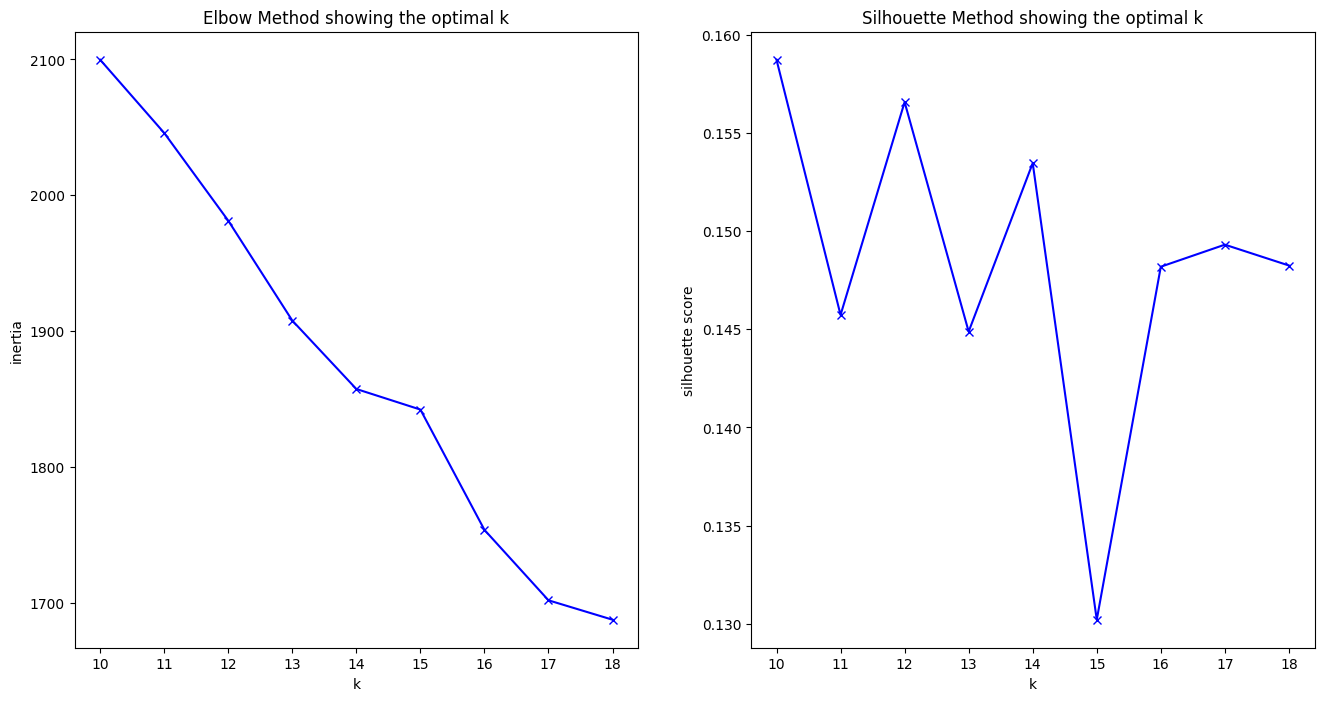

In [30]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

In [31]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as file: 
            return pickle.load(file) 
    except FileNotFoundError: 
        print("File not found!") 

In [34]:
best_model = load("../Models/kmeans_11.pickle")
best_model.fit(X_scaled_df)
clusters = best_model.predict(X_scaled_df)

X_scaled_df['cluster'] = clusters 
display(X_scaled_df.head())
X_scaled_df['cluster'].value_counts()

Initialization complete
Iteration 0, inertia 3634.486313924083.
Iteration 1, inertia 2426.3343121571925.
Iteration 2, inertia 2390.914817221373.
Iteration 3, inertia 2381.7347972373536.
Iteration 4, inertia 2380.8959632654955.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 3912.5106168574457.
Iteration 1, inertia 2481.520092977093.
Iteration 2, inertia 2336.7233080892947.
Iteration 3, inertia 2274.285439394458.
Iteration 4, inertia 2252.5081081136063.
Iteration 5, inertia 2244.5079375864348.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 3748.652827833228.
Iteration 1, inertia 2375.0961420126578.
Iteration 2, inertia 2354.484943323097.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3668.086382265433.
Iteration 1, inertia 2513.811236601856.
Iteration 2, inertia 2495.572176454527.
Iteration 3, inertia 2494.908164920695.
Converged at iteration 3: strict conve

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,release_year,release_decade,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,1.081388,-0.419957,-1.213500,-0.259743,0.468923,-0.611407,1.406166,-0.228419,-0.351448,-0.427780,3.443508,1
1,1.081388,-0.419957,-0.222439,0.092919,0.337165,-0.565355,-0.527774,1.010223,-0.290912,-0.870493,-1.517013,2
2,1.081388,-0.419957,-0.003938,-3.292642,-0.750474,-0.630369,3.796856,-0.228261,-0.623859,-2.203060,-0.470352,10
3,1.081388,-0.419957,-0.035152,0.228107,0.543285,-0.645268,1.520234,-0.228256,-0.758854,0.971193,1.031152,6
4,1.081388,-0.419957,1.002730,0.510237,0.532456,-0.578900,1.040195,-0.222664,-0.575431,0.829525,-0.738905,6


cluster
6     77
5     62
4     57
2     53
7     36
8     34
0     33
3     29
1     26
9     14
10    13
Name: count, dtype: int64

In [36]:
data['cluster'] = X_scaled_df['cluster']
display(data.isna().sum())
data.head()

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    1
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
hot                   0
cluster               0
dtype: int64

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot,cluster
0,Last Night,Morgan Wallen,2023-01-01,2023,20,2kRkndFdIh2PDDjB53N1CB,0.517,0.675,6,-5.382,...,0.518,203.853,audio_features,spotify:track:59uQI0PADDKeE6UZDTJEe8,https://api.spotify.com/v1/tracks/59uQI0PADDKe...,https://api.spotify.com/v1/audio-analysis/59uQ...,163855,4,Yes,1
1,Kill Bill,SZA,2023-01-01,2023,20,1Qrg8KqiBpW07V7PNxwwwL,0.644,0.735,8,-5.747,...,0.418,88.980,audio_features,spotify:track:1Qrg8KqiBpW07V7PNxwwwL,https://api.spotify.com/v1/tracks/1Qrg8KqiBpW0...,https://api.spotify.com/v1/audio-analysis/1Qrg...,153947,4,Yes,2
2,Flowers,Miley Cyrus,2023-01-01,2023,20,5tdKaKLnC4SgtDZ6RlWeal,0.672,0.159,9,-8.760,...,0.117,113.218,audio_features,spotify:track:0436pabrDTOgxH02ugHGBA,https://api.spotify.com/v1/tracks/0436pabrDTOg...,https://api.spotify.com/v1/audio-analysis/0436...,210827,4,Yes,10
3,Ella Baila Sola,Eslabon Armado X Peso Pluma,2023-01-01,2023,20,3dnP0JxCgygwQH9Gm7q7nb,0.668,0.758,5,-5.176,...,0.834,147.989,audio_features,spotify:track:3qQbCzHBycnDpGskqOWY0E,https://api.spotify.com/v1/tracks/3qQbCzHBycnD...,https://api.spotify.com/v1/audio-analysis/3qQb...,165671,3,Yes,6
4,Calm Down,Rema & Selena Gomez,2023-01-01,2023,20,0WtM2NBVQNNJLh6scP13H8,0.801,0.806,11,-5.206,...,0.802,106.999,audio_features,spotify:track:0WtM2NBVQNNJLh6scP13H8,https://api.spotify.com/v1/tracks/0WtM2NBVQNNJ...,https://api.spotify.com/v1/audio-analysis/0WtM...,239318,4,Yes,6
